In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


In [28]:
# Reading in data for station
df = pd.read_csv('../data/df_cleaned_year.csv')
df.head()

,datetime,c/a,unit,scp,station,linename,entries_abs,exits_abs,weekday
0,2022-04-16 04:00:00,H007,R248,00-00-00,1 AV,L,18,192,Saturday
1,2022-04-16 08:00:00,H007,R248,00-00-00,1 AV,L,8,101,Saturday
2,2022-04-16 12:00:00,H007,R248,00-00-00,1 AV,L,62,273,Saturday
3,2022-04-16 16:00:00,H007,R248,00-00-00,1 AV,L,91,473,Saturday
4,2022-04-16 20:00:00,H007,R248,00-00-00,1 AV,L,115,484,Saturday


In [29]:
# Selecting Penn Station
df = df[df['station'] == '34 ST-PENN STA']
df

,datetime,c/a,unit,scp,station,linename,entries_abs,exits_abs,weekday
962725,2022-04-16 04:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,8,21,Saturday
962726,2022-04-16 08:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,23,97,Saturday
962727,2022-04-16 12:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,62,317,Saturday
962728,2022-04-16 16:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,113,343,Saturday
962729,2022-04-16 20:00:00,N067,R012,00-00-00,34 ST-PENN STA,ACE,96,280,Saturday
...,...,...,...,...,...,...,...,...,...
1073409,2022-10-14 04:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,10,25,Friday
1073410,2022-10-14 08:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,85,64,Friday
1073411,2022-10-14 12:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,104,89,Friday
1073412,2022-10-14 16:00:00,N072,R012,05-03-06,34 ST-PENN STA,ACE,58,259,Friday


In [4]:
# Looking at the columns and types 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110689 entries, 962725 to 1073413
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   datetime     110689 non-null  object
 1   c/a          110689 non-null  object
 2   unit         110689 non-null  object
 3   scp          110689 non-null  object
 4   station      110689 non-null  object
 5   linename     110689 non-null  object
 6   entries_abs  110689 non-null  int64 
 7   exits_abs    110689 non-null  int64 
 8   weekday      110689 non-null  object
dtypes: int64(2), object(7)
memory usage: 8.4+ MB


In [ ]:
# Setting the datetime to a datetime object and setting as index
df['datetime'] = pd.to_datetime(df['datetime'])

#Using the groupby to add up the entries and exits for each time
df = df.groupby('datetime').sum()
df.head()

#Renaming the columns and sorting the index
df.rename(columns = {'entries_abs':'entries', 'exits_abs':'exits'}, inplace = True)
df.sort_index(inplace = True)
df.index.freq = '4H'

#Adding column for entries + exits called traffic
df['traffic'] = df['entries'] + df['exits']
df.head()

In [7]:
def plot_series(df, cols, title='Title', xlab=None, ylab=None):
    """Function to plot columns for a time period"""
    
    # Set figure size to be (18, 9).
    plt.figure(figsize=(18,9))
    
    # Iterate through each column name.
    for col in cols:
        
        # Generate a line plot of the column name.
        # You only have to specify Y, since our
        # index will be a datetime index.
        plt.plot(df[col], label = col)
        
    # Generate title and labels.
    plt.title(title, fontsize=26)
    plt.xlabel(xlab, fontsize=20)
    plt.ylabel(ylab, fontsize=20)
    
    # Enlarge tick marks.
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    
    plt.legend();

# Plots of the data

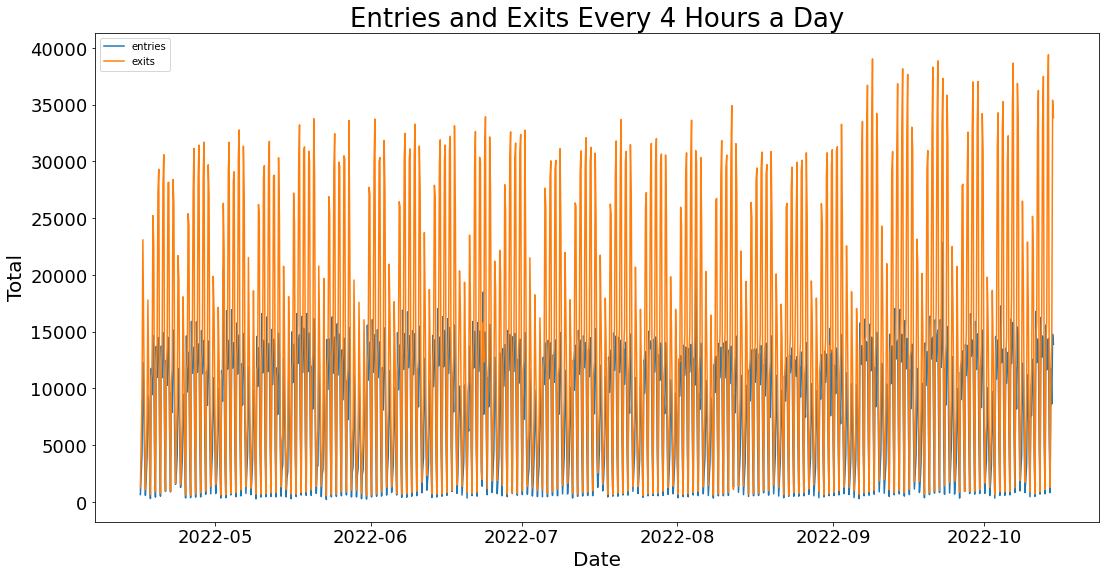

In [8]:
plot_series(df, cols = ['entries', 'exits'], title = 'Entries and Exits Every 4 Hours a Day', xlab = 'Date', ylab = 'Total')

In [9]:
#plot_series(df, cols = ['exits'], title = 'Exits per time of day')

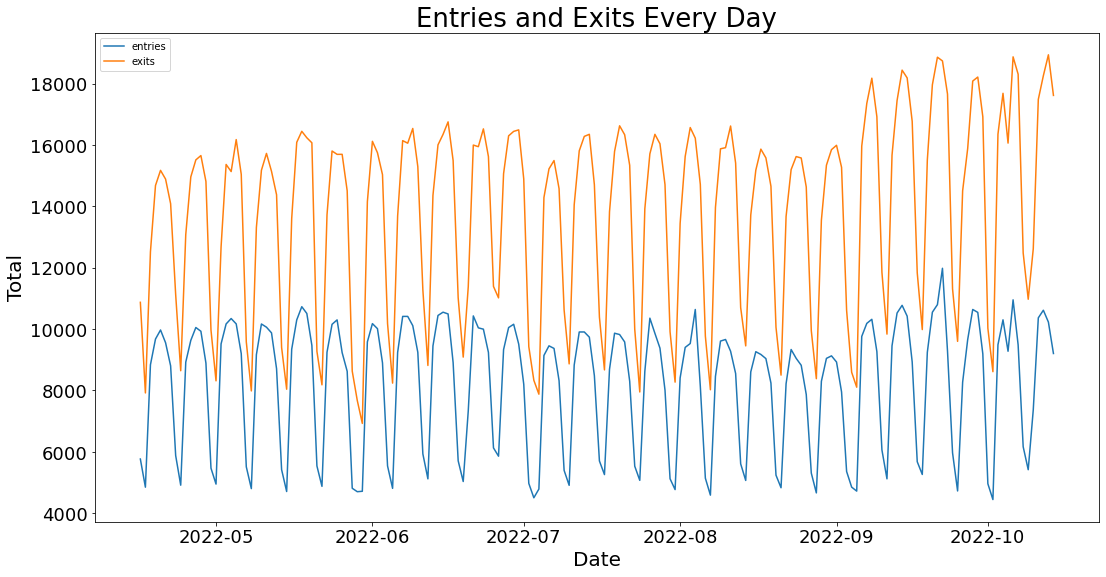

In [10]:
df_daily = df.resample('D').mean()
plot_series(df_daily, cols = ['entries', 'exits'], title = 'Entries and Exits Every Day', xlab = 'Date', ylab = 'Total')

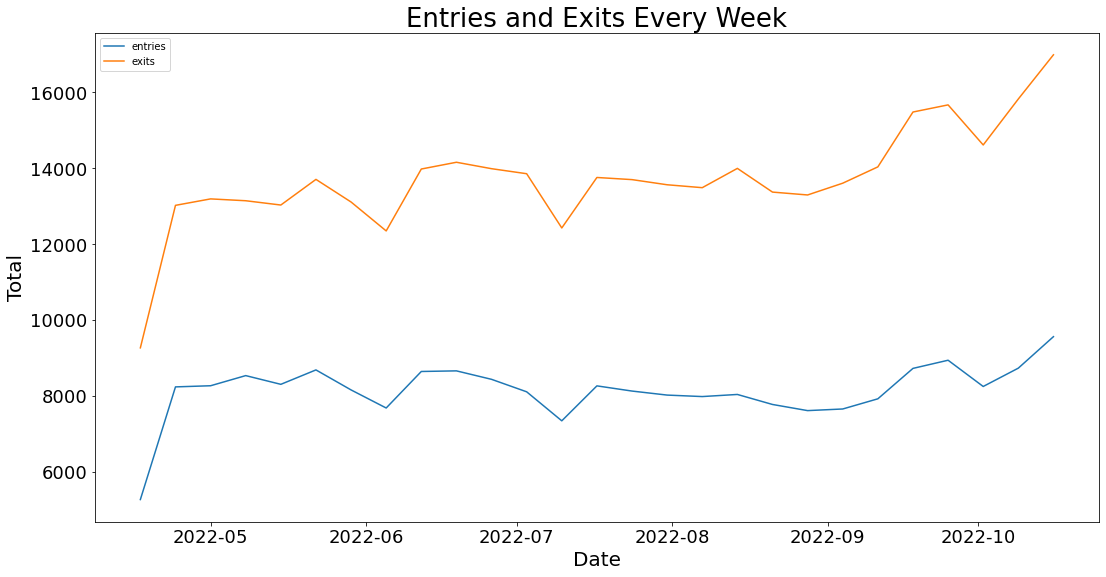

In [11]:
df_weekly = df.resample('W').mean()
plot_series(df_weekly, cols = ['entries', 'exits'], title = 'Entries and Exits Every Week', xlab = 'Date', ylab = 'Total')

# Evaluating For Stationarity

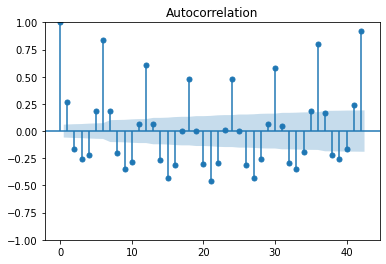

In [12]:
plot_acf(df['entries'], lags = 42);

- We can see that we have high correlation in every lag of 6. This is because for each lag of 6 an entire day passes. It also gets extremely high once it reaches 42 because thats after an entire week passes.

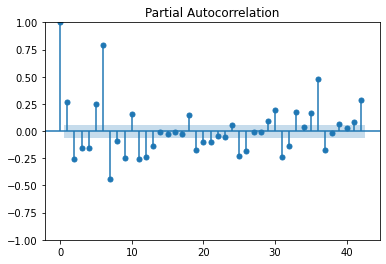

In [13]:
plot_pacf(df['entries'], lags = 42, method = 'ywm');

 - Using the pacf we can see that some of the correlation the acf was showing us was due to lags having a correlation to the lags in between the first lag. The majority of the lags of multiples of 6 are still standing out, but some of the negative lags in between for the autocorrelation below the significance threshold now. 

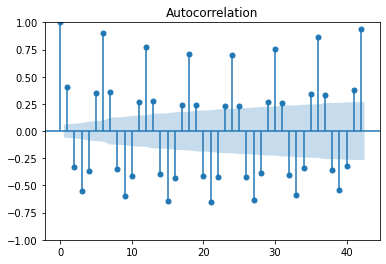

In [14]:
plot_acf(df['exits'], lags = 42);

- Opposed to the entries acf we have more negatively correlated lags and their significance is almost just as high as the positive lags' correlation.

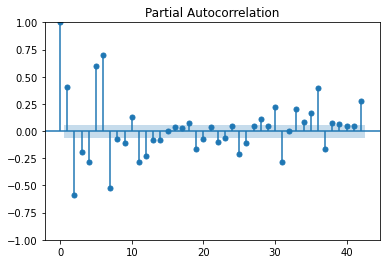

In [15]:
plot_pacf(df['exits'], lags = 42, method = 'ywm');

- We get the same drop off again however and see that most of the lags are the middle aren't as significant as they were in comparison to the acf.

In [16]:
# Use the augmented dickey-fuller test to test if our data is stationary
# Code from lesson on Arima Models to extract needed values 
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [17]:
interpret_dftest(adfuller(df['entries']))

Test Statistic   -1.144211e+01
p-value           6.142676e-21
dtype: float64

In [18]:
interpret_dftest(adfuller(df['exits']))

Test Statistic   -1.035992e+01
p-value           2.411413e-18
dtype: float64

- Since we have p values of less than 0.05 we can confidently say our data is stationary. This means we won't have to difference our data for our AR model

# Evaluating AR Models For Entries

In [19]:
def AR_model_gridsearch(df, p_values, d_values, q_values):
    
    #Creating train test split for data
    y_train, y_test = train_test_split(df, test_size = 0.2, shuffle = False)
    
    best_aic = 999999
    best_order  = (0, 0, 0)
    for p in p_values: 
        for d in d_values:
            for q in q_values:
                try: 
                    
                    print(f'ARIMA:({p},{d},{q})')
                    
                    arima = ARIMA(endog = y_train, order = (p, d, q), freq = '4H')
                    
                    model = arima.fit()
                    
                    print(f'The AIC for ARIMA({p}, 0, {q}) is : {model.aic}')
                    
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_order = (p, d, q)
                        
                except:
                    print('failed')
                    pass
                
    print()
    print()
    print(f'Our model that minimizes AIC on the training data is the ARIMA{best_order}.')
    print(f'This model has an AIC of {best_aic}.')
    return best_order

In [20]:
def evaluate_model(df, p_value, d_value, q_value):
    y_train, y_test = train_test_split(df, test_size = 0.05, shuffle = False)

    arima = ARIMA(endog = y_train, order = (p_value, d_value, q_value), freq = '4H')
    
    model = arima.fit()

    preds = model.predict(start = y_test.index[0], end = y_test.index[-1])
    print(model.summary())
    print(f'RMSE: {mean_squared_error(y_test, preds, squared = False)}')
    
    plt.figure(figsize = (10, 6))
    plt.plot(y_test, label = 'y_test')
    plt.plot(y_test.index, preds, label = 'test_pred')
    plt.legend();

In [21]:
p_values = range(0,20)
d_values = [0] #Since the data is already stationary
q_values = [0] # To check the MA of 1 lag

p, d, q = AR_model_gridsearch(df['entries'], p_values, d_values, q_values)

ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 22444.724699822855
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 17349.850059257187
ARIMA:(2,0,0)
The AIC for ARIMA(2, 0, 0) is : 17291.68073764131
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 17267.376672559207
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 17249.861158157706
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 17199.867315088093
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 16307.485349721006
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 16107.548119163346
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 16101.566948122269
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 16046.950957130088
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 16027.255944056176
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 15972.546314890555
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 15920.111319142052
ARIMA:(13,0,0)
The AIC for ARIMA(13, 0, 0) is : 15905.60266956404
ARIMA:(14,0,0)
The AIC for ARIMA(14, 0, 0) is : 15907.204002426699
ARIMA:(15,0,0)
Th

                               SARIMAX Results                                
Dep. Variable:                entries   No. Observations:                 1036
Model:                ARIMA(19, 0, 0)   Log Likelihood               -9411.135
Date:                Sun, 23 Oct 2022   AIC                          18864.269
Time:                        16:49:34   BIC                          18968.075
Sample:                    04-16-2022   HQIC                         18903.655
                         - 10-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8169.4788    163.721     49.899      0.000    7848.592    8490.366
ar.L1          0.4137      0.044      9.424      0.000       0.328       0.500
ar.L2         -0.1070      0.040     -2.661      0.0

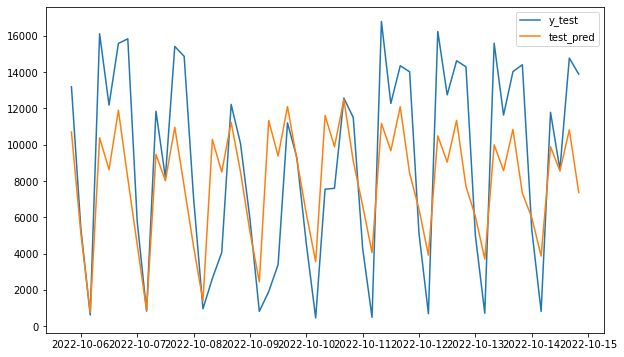

In [22]:
evaluate_model(df['entries'], p, d, q)

# Evaluating Models for Exits

In [23]:
p_values = range(0,20)
d_values = [0] #Since the data is already stationary
q_values = [0] # To check the MA of 1 lag

p, d, q = AR_model_gridsearch(df['exits'], p_values, d_values, q_values)

ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 23572.98856332864
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 18389.699304973197
ARIMA:(2,0,0)
The AIC for ARIMA(2, 0, 0) is : 18024.315538626273
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 17984.235622780434
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 17914.431690974176
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 17580.292109637525
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 16922.45497047375
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 16622.677446240785
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 16616.0268231324
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 16604.29966935311
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 16585.868122303767
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 16510.648095846984
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 16444.10746679485
ARIMA:(13,0,0)
The AIC for ARIMA(13, 0, 0) is : 16436.99600671851
ARIMA:(14,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(14, 0, 0) is : 16432.56227319389
ARIMA:(15,0,0)
The AIC for ARIMA(15, 0, 0) is : 16434.55582165406
ARIMA:(16,0,0)
The AIC for ARIMA(16, 0, 0) is : 16435.479709589068
ARIMA:(17,0,0)
The AIC for ARIMA(17, 0, 0) is : 16437.33424595325
ARIMA:(18,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(18, 0, 0) is : 16433.9198179328
ARIMA:(19,0,0)


C:\Users\injun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The AIC for ARIMA(19, 0, 0) is : 16395.55586835248


Our model that minimizes AIC on the training data is the ARIMA(19, 0, 0).
This model has an AIC of 16395.55586835248.


                               SARIMAX Results                                
Dep. Variable:                  exits   No. Observations:                 1036
Model:                ARIMA(19, 0, 0)   Log Likelihood               -9752.954
Date:                Sun, 23 Oct 2022   AIC                          19547.907
Time:                        16:50:49   BIC                          19651.713
Sample:                    04-16-2022   HQIC                         19587.293
                         - 10-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.367e+04    246.575     55.438      0.000    1.32e+04    1.42e+04
ar.L1          0.4951      0.033     15.056      0.000       0.431       0.560
ar.L2         -0.0598      0.040     -1.494      0.1

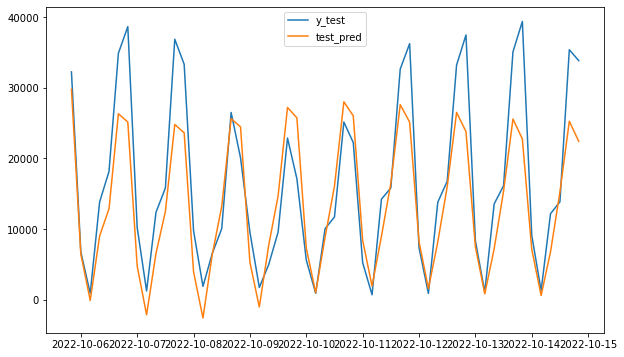

In [24]:
evaluate_model(df['exits'], p, d, q)


# Evaluating Models for Traffic

In [25]:
p_values = range(0,20)
d_values = [0] #Since the data is already stationary
q_values = [0] # To check the MA of 1 lag

p, d, q = AR_model_gridsearch(df['traffic'], p_values, d_values, q_values)

ARIMA:(0,0,0)
The AIC for ARIMA(0, 0, 0) is : 24250.818868337265
ARIMA:(1,0,0)
The AIC for ARIMA(1, 0, 0) is : 19094.79123421425
ARIMA:(2,0,0)
The AIC for ARIMA(2, 0, 0) is : 18872.468092625943
ARIMA:(3,0,0)
The AIC for ARIMA(3, 0, 0) is : 18832.897112494826
ARIMA:(4,0,0)
The AIC for ARIMA(4, 0, 0) is : 18787.415902185967
ARIMA:(5,0,0)
The AIC for ARIMA(5, 0, 0) is : 18593.626170426025
ARIMA:(6,0,0)
The AIC for ARIMA(6, 0, 0) is : 17754.694895593304
ARIMA:(7,0,0)
The AIC for ARIMA(7, 0, 0) is : 17439.27469203076
ARIMA:(8,0,0)
The AIC for ARIMA(8, 0, 0) is : 17421.045292214105
ARIMA:(9,0,0)
The AIC for ARIMA(9, 0, 0) is : 17383.31285149059
ARIMA:(10,0,0)
The AIC for ARIMA(10, 0, 0) is : 17314.248786964792
ARIMA:(11,0,0)
The AIC for ARIMA(11, 0, 0) is : 17229.825167396033
ARIMA:(12,0,0)
The AIC for ARIMA(12, 0, 0) is : 17144.257119344824
ARIMA:(13,0,0)
The AIC for ARIMA(13, 0, 0) is : 17101.99967020335
ARIMA:(14,0,0)
The AIC for ARIMA(14, 0, 0) is : 17102.684934102337
ARIMA:(15,0,0)
The 

                               SARIMAX Results                                
Dep. Variable:                traffic   No. Observations:                 1036
Model:                ARIMA(19, 0, 0)   Log Likelihood              -10091.719
Date:                Sun, 23 Oct 2022   AIC                          20225.438
Time:                        16:52:03   BIC                          20329.243
Sample:                    04-16-2022   HQIC                         20264.823
                         - 10-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.184e+04    283.205     77.114      0.000    2.13e+04    2.24e+04
ar.L1          0.4726      0.038     12.597      0.000       0.399       0.546
ar.L2          0.0098      0.035      0.280      0.7

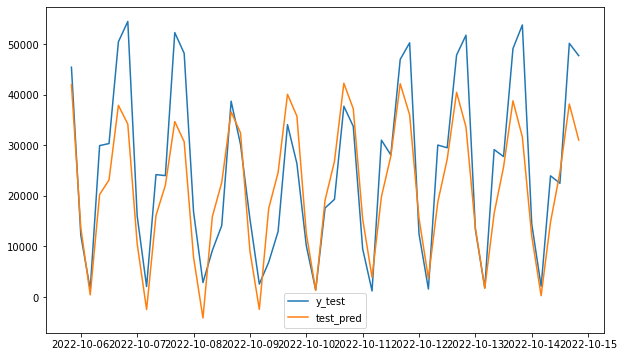

In [26]:
evaluate_model(df['traffic'], p, d, q)
